<a href="https://colab.research.google.com/github/AsheriasI/geometric_learning/blob/main/gnn_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Neural Network for Link Prediction on Synthetic Data

Welcome to this Google Colab notebook! In this project, we'll:
1. Generate a **synthetic social network** using NetworkX.
2. Convert it to a PyTorch Geometric `Data` object.
3. Implement a simple **Graph Convolutional Network (GCN)** for **link prediction**.
4. Evaluate the model using metrics such as **AUC**, **Precision**, **Recall**, and **F1**.
5. Visualize some of our results (ROC curve, node embeddings).



In [29]:
# !pip install torch>=1.12 torch-geometric --quiet
# !pip install networkx matplotlib seaborn scikit-learn --quiet


In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import random

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch Geometric imports
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv

# Sklearn metrics
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, roc_curve
)
from sklearn.model_selection import train_test_split

# Set default plotting style
sns.set_style("whitegrid")

# Set random seeds for reproducibility
seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)


Using device: cuda


### Synthetic Data Generation

We'll use the **Erdős–Rényi model** (`nx.erdos_renyi_graph`) to generate a random graph of a specified size.
Each node will have a random feature vector. We'll keep it small enough so that visualization and training
times remain fast in Colab (T4).


In [31]:
# Parameters for synthetic graph
num_nodes = 200
p = 0.05  # Probability of edge creation in the Erdos-Renyi model

# Generate the synthetic graph
G = nx.erdos_renyi_graph(n=num_nodes, p=p)
G = G.to_undirected()  # Ensure it's undirected

# Assign random 5-dimensional feature vectors to each node
node_features = {}
for node in G.nodes():
    node_features[node] = np.random.rand(5)
nx.set_node_attributes(G, node_features, 'x')

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")


Number of nodes: 200
Number of edges: 942


In [32]:
# Convert to PyTorch Geometric Data
data = from_networkx(G)
data.x = data.x.float()
print(data)

# Move data to device
data = data.to(device)

# Check shapes
print("Node feature matrix shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)


Data(x=[200, 5], edge_index=[2, 1884])
Node feature matrix shape: torch.Size([200, 5])
Edge index shape: torch.Size([2, 1884])


### Exploratory Data Analysis

We can look at the node degree distribution and visualize a subgraph to get a sense of how our synthetic data is structured.


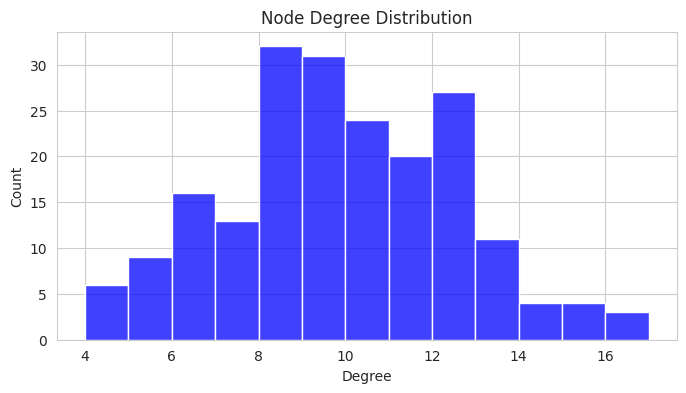

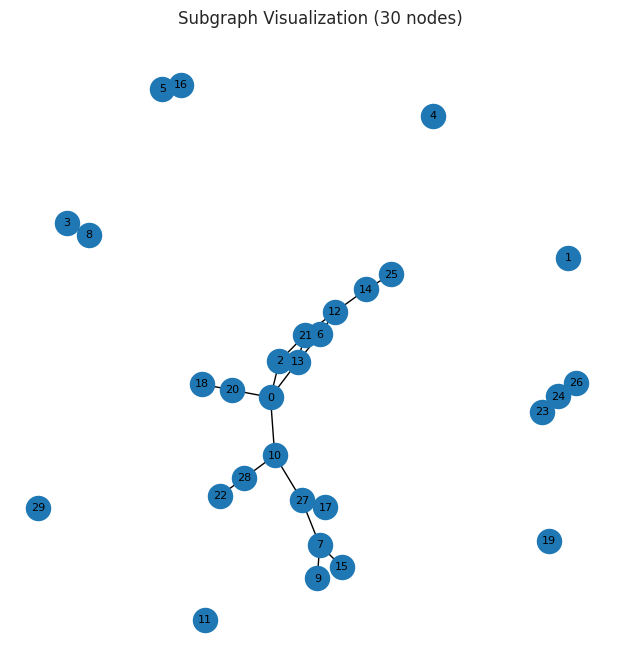

In [33]:
# Plot degree distribution
degrees = [val for (_, val) in G.degree()]
plt.figure(figsize=(8, 4))
sns.histplot(degrees, kde=False, color='blue')
plt.title("Node Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.show()

# Visualize a subgraph of first 30 nodes (if the graph is small enough, or you can try the entire graph)
sub_nodes = list(G.nodes())[:30]
sub_G = G.subgraph(sub_nodes)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(sub_G, seed=seed)
nx.draw_networkx(sub_G, pos, with_labels=True, node_size=300, font_size=8)
plt.title("Subgraph Visualization (30 nodes)")
plt.axis('off')
plt.show()


### Negative Sampling

For link prediction, we need negative samples (pairs of nodes that are *not* connected). We'll create a
1:1 ratio of positive to negative edges.


In [34]:
# Extract positive edges from data
edges_positive = data.edge_index.t().cpu().numpy().tolist()
num_nodes = data.num_nodes

# Build a set of existing edges for quick lookup
edge_set = set()
for e in edges_positive:
    edge_set.add((e[0], e[1]))
    edge_set.add((e[1], e[0]))  # undirected

# Generate negative edges
edges_negative = []
neg_samples_needed = len(edges_positive)  # 1:1 ratio
attempts = 0
max_attempts = 100000

while len(edges_negative) < neg_samples_needed and attempts < max_attempts:
    i = np.random.randint(0, num_nodes)
    j = np.random.randint(0, num_nodes)
    if i != j:
        if (i, j) not in edge_set and (j, i) not in edge_set:
            edges_negative.append([i, j])
            edge_set.add((i, j))
            edge_set.add((j, i))
    attempts += 1

print(f"Positive edges: {len(edges_positive)}")
print(f"Negative edges: {len(edges_negative)}")


Positive edges: 1884
Negative edges: 1884


In [35]:
# Prepare data for training
edges_all = edges_positive + edges_negative
y_all = [1]*len(edges_positive) + [0]*len(edges_negative)

edges_all = np.array(edges_all)
y_all = np.array(y_all)

# Stratified split to keep balanced classes in train/test
edges_train, edges_test, y_train, y_test = train_test_split(
    edges_all, y_all, test_size=0.3, stratify=y_all, random_state=seed
)

edges_train = torch.tensor(edges_train, dtype=torch.long, device=device)
y_train = torch.tensor(y_train, dtype=torch.float, device=device)
edges_test = torch.tensor(edges_test, dtype=torch.long, device=device)
y_test = torch.tensor(y_test, dtype=torch.float, device=device)

print("Train edges:", edges_train.shape[0])
print("Test edges:", edges_test.shape[0])


Train edges: 2637
Test edges: 1131


### Model Definition

We'll use a simple **two-layer GCN** to learn node embeddings.  
Then, for link prediction, we'll either do a *dot product* of the two node embeddings or a simple MLP.  
Here, we'll do a dot product for simplicity:

$\text{score}(u,v) = \sum_{d} z_u[d] \times z_v[d]$

We'll then apply a sigmoid to this score to get a probability of a link.


In [36]:
class GCNEncoder(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

class LinkPredictor(nn.Module):
    def __init__(self, encoder):
        super(LinkPredictor, self).__init__()
        self.encoder = encoder

    def forward(self, x, edge_index, edge_pairs):
        # Generate node embeddings
        z = self.encoder(x, edge_index)
        # Dot product for each edge
        z_edge = z[edge_pairs[:,0]] * z[edge_pairs[:,1]]
        # Sum across feature dimension -> shape [num_edges]
        return torch.sum(z_edge, dim=1)

# Instantiate model
in_channels = data.num_node_features  # 5 from our synthetic features
hidden_channels = 16
out_channels = 16  # final embedding dimension

encoder = GCNEncoder(in_channels, hidden_channels, out_channels)
model = LinkPredictor(encoder).to(device)

print(model)


LinkPredictor(
  (encoder): GCNEncoder(
    (conv1): GCNConv(5, 16)
    (conv2): GCNConv(16, 16)
  )
)


In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

num_epochs = 100

for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index, edges_train)
    loss = loss_fn(logits, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"[Epoch {epoch}] Training Loss: {loss.item():.4f}")


[Epoch 10] Training Loss: 0.6928
[Epoch 20] Training Loss: 0.6923
[Epoch 30] Training Loss: 0.6912
[Epoch 40] Training Loss: 0.6901
[Epoch 50] Training Loss: 0.6883
[Epoch 60] Training Loss: 0.6857
[Epoch 70] Training Loss: 0.6820
[Epoch 80] Training Loss: 0.6766
[Epoch 90] Training Loss: 0.6706
[Epoch 100] Training Loss: 0.6676


### Evaluation

We'll compute:
- **AUC** (Area Under the ROC Curve)
- **Accuracy**
- **Precision**
- **Recall**
- **F1 Score**

We also generate a **ROC curve** plot to visualize performance.


In [38]:
model.eval()
with torch.no_grad():
    logits_test = model(data.x, data.edge_index, edges_test)
    probs_test = torch.sigmoid(logits_test)

# Convert to CPU numpy for sklearn metrics
y_test_np = y_test.cpu().numpy()
probs_test_np = probs_test.cpu().numpy()
preds_test_np = (probs_test_np > 0.5).astype(int)

auc_score = roc_auc_score(y_test_np, probs_test_np)
acc = accuracy_score(y_test_np, preds_test_np)
precision = precision_score(y_test_np, preds_test_np)
recall = recall_score(y_test_np, preds_test_np)
f1 = f1_score(y_test_np, preds_test_np)

print(f"AUC:       {auc_score:.4f}")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1:        {f1:.4f}")


AUC:       0.6289
Accuracy:  0.5853
Precision: 0.5606
Recall:    0.7858
F1:        0.6544


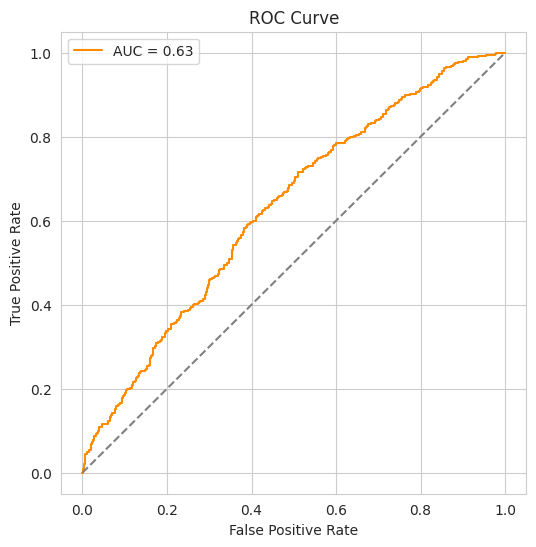

<ipython-input-39-71e13eab7184>:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z_2d[:,0], z_2d[:,1], s=30, cmap='viridis')


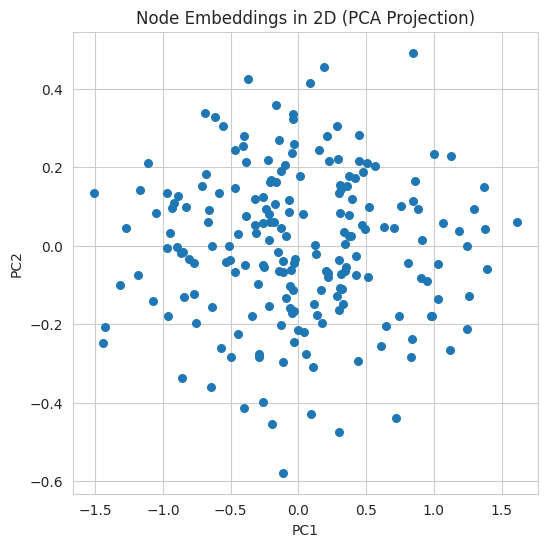

In [39]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_np, probs_test_np)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}", color='darkorange')
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Optional: Visualize the learned embeddings via PCA
from sklearn.decomposition import PCA

model.eval()
with torch.no_grad():
    z = model.encoder(data.x, data.edge_index).cpu().numpy()

pca = PCA(n_components=2)
z_2d = pca.fit_transform(z)

plt.figure(figsize=(6,6))
plt.scatter(z_2d[:,0], z_2d[:,1], s=30, cmap='viridis')
plt.title("Node Embeddings in 2D (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


## Conclusion

- We generated a synthetic social network of 200 nodes using an Erdős–Rényi model.
- A simple two-layer GCN was used to encode node embeddings.
- Using a dot-product edge predictor, we achieved a certain level of accuracy (see the above metrics).
- The AUC metric, in particular, shows how well our model distinguishes real vs. fake edges.

Overall, **GCNs** can be a powerful approach for link prediction even on small synthetic graphs. For a real-world scenario,
we would need to handle much larger graphs, possibly adopt mini-batching and more sophisticated negative sampling strategies.


## Future Work

1. **Use More Advanced GNN Architectures**  
   - Experiment with **Graph Attention Networks (GAT)** or **GraphSAGE**
     to handle larger or more complex graphs.

2. **Hyperparameter Tuning**  
   - Systematically vary learning rate, number of layers, and hidden dimensions.
   - Use libraries like Optuna or Ray Tune for efficient tuning.

3. **Alternative Negative Sampling**  
   - Try more nuanced sampling approaches that account for node degrees
     or existing connectivity patterns.

4. **Real-World Datasets**  
   - Move beyond synthetic data. For instance, use the **Cora** dataset
     or **Reddit** hyperlink network for more realistic benchmarking.

5. **Explainability & Interpretability**  
   - Investigate which node features or edges are most influential in
     predicting the existence of a link.

6. **Temporal Link Prediction**  
   - Incorporate time-based edges to predict how the network evolves over time.

If you are still reading this and have any recommendations then please feel free to reach out!
